<a href="https://colab.research.google.com/github/Kalaiselvan88/MLAssignments/blob/main/ML2Assignment1_Notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setting the environment variables

In [ ]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [ ]:
# initialising the session with 14 GB driver memory
from pyspark import SparkConf
from pyspark.sql import SparkSession

MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("logistic regression") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [ ]:
# Loading the clean data
df = spark.read.parquet('cleaned_df.parquet')
df.count()

28650604

<hr>

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 1: Logistic Regression

In [ ]:
# Additional steps for Logistic regression - Feature selection, Correlation, etc.
df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- cat_l1: string (nullable = true)
 |-- cat_l2: string (nullable = true)
 |-- hour_bucket: double (nullable = true)
 |-- brand_red: string (nullable = true)
 |-- is_purchased: integer (nullable = true)



In [ ]:
df.stat.corr("hour_bucket","price")

0.011142546204611062

#### There are no columns which might have any correlation

#### Feature Transformation

In [ ]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns

# Here we are dropping category_id since we have the category details in cat_l1 and cat_l2
# We are also dropping user_session since it has many unique values which might take a lot of time
# to do OneHotEncoder and moreover it is not very much helpful for Churn prediction and has already been used for EDA
df_logistic = df.drop('category_id', 'user_session')
df_logistic = df_logistic.dropDuplicates()
df_logistic.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- cat_l1: string (nullable = true)
 |-- cat_l2: string (nullable = true)
 |-- hour_bucket: double (nullable = true)
 |-- brand_red: string (nullable = true)
 |-- is_purchased: integer (nullable = true)



In [ ]:
# Categorising the attributes into its type - Continuous and Categorical

#### The above list of features can be split based on the transformations required as follows

#### Continuous columns with numerical data - No processing required
 - product_id
 - price
 - user_id
 
#### Here product_id and user_id are just identifiers and we do not need them

#### Nominal categorical variables represented with integers. - One-hot encoding
 - day_of_week
 - hour_bucket

#### Nominal Categorical variables represented with strings - String indexer + One hot encoding
 - cat_l1
 - cat_l2
 - brand_red

In [ ]:
# Feature transformation for categorical features
#import the string indexer
from pyspark.ml.feature import StringIndexer
#import the onehot encoder
from pyspark.ml.feature import OneHotEncoderEstimator


si1 = StringIndexer(inputCol= 'cat_l1', outputCol='cat_l1_ix')
si2 = StringIndexer(inputCol= 'cat_l2', outputCol='cat_l2_ix')
si3 = StringIndexer(inputCol= 'brand_red', outputCol='brand_red_ix')

cat_indx = ['cat_l1_ix','cat_l2_ix','brand_red_ix','day_of_week','hour_bucket']

ohe = OneHotEncoderEstimator(inputCols=cat_indx,
                             outputCols=['cat_l1_en','cat_l2_en','brand_red_en','day_of_week_en','hour_bucket_en'])

In [ ]:
# Vector assembler to combine all the features
#import the vector assembler 
from pyspark.ml.feature import VectorAssembler
cols = ['price','cat_l1_en','cat_l2_en','brand_red_en','day_of_week_en','hour_bucket_en']
assembler = VectorAssembler(inputCols=cols,
                            outputCol="features")

In [ ]:
# Pipeline for the tasks
# import pipline API
from pyspark.ml import Pipeline

In [ ]:
# Transforming the dataframe df
#create the pipeline object
pipeline = Pipeline(stages=[si1, si2, si3, ohe, assembler])

#use the object to transform the dataframe 
df_logistic_encoded = pipeline.fit(df_logistic).transform(df_logistic)
df_logistic_encoded.select("features").show()

+--------------------+
|            features|
+--------------------+
|(101,[0,2,14,71,9...|
|(101,[0,4,20,84,9...|
|(101,[0,7,22,71,9...|
|(101,[0,2,14,71,9...|
|(101,[0,1,17,80,9...|
|(101,[0,9,39,71,9...|
|(101,[0,1,15,73,9...|
|(101,[0,1,15,74,9...|
|(101,[0,3,35,71,9...|
|(101,[0,3,16,72,9...|
|(101,[0,2,14,77,9...|
|(101,[0,1,15,75,9...|
|(101,[0,1,15,72,9...|
|(101,[0,2,14,77,9...|
|(101,[0,3,21,71,9...|
|(101,[0,11,37,71,...|
|(101,[0,6,25,71,9...|
|(101,[0,2,14,71,9...|
|(101,[0,3,16,78,9...|
|(101,[0,1,15,73,9...|
+--------------------+
only showing top 20 rows



In [ ]:
# Schema of the transformed df
df_logistic_encoded.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- cat_l1: string (nullable = true)
 |-- cat_l2: string (nullable = true)
 |-- hour_bucket: double (nullable = true)
 |-- brand_red: string (nullable = true)
 |-- is_purchased: integer (nullable = true)
 |-- cat_l1_ix: double (nullable = false)
 |-- cat_l2_ix: double (nullable = false)
 |-- brand_red_ix: double (nullable = false)
 |-- cat_l1_en: vector (nullable = true)
 |-- day_of_week_en: vector (nullable = true)
 |-- hour_bucket_en: vector (nullable = true)
 |-- brand_red_en: vector (nullable = true)
 |-- cat_l2_en: vector (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# Checking the elements of the transformed df - Top 20 rows
df_logistic_encoded.show()

+----------+-------+---------+-----------+-----------+-----------+-----------+---------+------------+---------+---------+------------+---------------+--------------+--------------+---------------+---------------+--------------------+
|product_id|  price|  user_id|day_of_week|     cat_l1|     cat_l2|hour_bucket|brand_red|is_purchased|cat_l1_ix|cat_l2_ix|brand_red_ix|      cat_l1_en|day_of_week_en|hour_bucket_en|   brand_red_en|      cat_l2_en|            features|
+----------+-------+---------+-----------+-----------+-----------+-----------+---------+------------+---------+---------+------------+---------------+--------------+--------------+---------------+---------------+--------------------+
|  18001431|  13.15|541090104|          2|         NA|         NA|        3.0|   others|           0|      1.0|      0.0|         0.0| (13,[1],[1.0])| (7,[2],[1.0])|     (3,[],[])| (20,[0],[1.0])| (57,[0],[1.0])|(101,[0,2,14,71,9...|
|   1307520| 848.67|548553561|          3|  computers|   noteboo

In [ ]:
# Checking positive class count
df_logistic_encoded.filter(df_logistic_encoded.is_purchased == 1).count()

662102

#### Train-test split

In [ ]:
# Splitting the data into train and test (Remember you are expected to compare the model later)
df_log_train, df_log_test = df_logistic_encoded.randomSplit([0.7,0.3])

In [ ]:
# Number of rows in train and test data
df_log_train.count()

19253924

In [ ]:
df_log_test.count()

8253697

#### Model Fitting

In [ ]:
# Building the model
# import the logistic model
from pyspark.ml.classification import LogisticRegression

# create the logistic model, configure it and call fit it to the data. 
lr1 = LogisticRegression(featuresCol='features', labelCol='is_purchased')

In [ ]:
# Fitting the model on transformed df
model1 = lr1.fit(df_log_train)

#### Model Analysis

Required Steps:
- Fit on test data
- Performance analysis
    - Appropriate Metric with reasoning
    - Threshold selection

In [ ]:
# use the model to predict the class labels of test data. 
model1_result = model1.evaluate(df_log_test)

In [ ]:
model1_result.recallByLabel

[1.0, 0.0]

In [ ]:
model1_result.precisionByLabel

[0.9759523520187378, 0.0]

#### The label we are interested in is 1, where the customer purchases the product. 
#### We should be able to identify if a customer will purchase a product more accurately
#### But as we can see above, we are not doing it as the recall for purchase=1 is 0

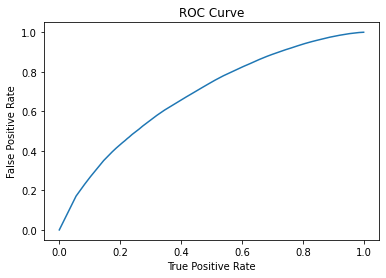

TestSet areaUnderROC: 0.6815226653139731


In [ ]:
# Checking ROC curve
import matplotlib.pyplot as plt
lr_model_sum = model1.summary
lr_roc = lr_model_sum.roc.toPandas()
plt.plot(lr_roc['FPR'],lr_roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('TestSet areaUnderROC: ' + str(lr_model_sum.areaUnderROC))

In [ ]:
# Create a new data frame with only the columns y and probabilities 
thresh = model1_result.predictions.select('is_purchased','probability')

In [ ]:
# the probability is a dense vector column. 
# You will have to find a way to access the value of the probability referring to the positive class. 
# create a function to access the probability of the positive class form the 'probability' column

from pyspark.sql.functions import udf, when
from pyspark.sql.types import FloatType

element_extrac=udf(lambda v:float(v[1]),FloatType())

In [ ]:
# create a list of all the thresholds you want to check the metrics for. 

result_list = []       # to store the values of precision and recall

threshold_list = [0.1,0.3,0.5,0.7,0.9]

In [ ]:
# Now you have the probabilities, your task is to add a class column. 
# To create this column, compare the probabilities with the threshold and decide the class. 
# You can make a loop which will repeat the same action for different thresholds
# Use the filter and count functions to find the true positives, false positives, false negatives. (inside the loop)
# Using these values, find the precision and recall for different thresholds. (inside the loop)


for i in threshold_list:
    test_pred = thresh.withColumn('label_p',when(element_extrac(thresh["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("is_purchased==1 AND label_p==1").count()
    FP = test_pred.filter("is_purchased==0 AND label_p==1").count()
    FN = test_pred.filter("is_purchased==1 AND label_p==0").count()
    TN = test_pred.filter("is_purchased==0 AND label_p==0").count()    
    recall = (TP/(TP+FN))
    if TP == 0:
        presession = 0.0
    else:
        presession = ((TP/(TP+FP)))
    list1 = []
    list1.append(i)
    list1.append(presession)
    list1.append(recall)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

In [ ]:
# Create a panadas datafarme for the list of the output. 

# create a schema for the dataframes 
from pyspark.sql.types import *

schema = StructType([StructField('threshold', FloatType(), True),
                      StructField('precision', FloatType(), True),
                      StructField('recall', FloatType(), True),
                      StructField('TP', IntegerType(), True),
                      StructField('TN', IntegerType(), True),
                      StructField('FP', IntegerType(), True),
                      StructField('FN', IntegerType(), True)])


# create a rdd from the list
rdd = spark.sparkContext.parallelize(result_list)


# create a spark dataframe form rdd
thresh_df = spark.createDataFrame(rdd,schema)

# create pandas dataframe form the spark dataframe 
pandas_df = thresh_df.toPandas()

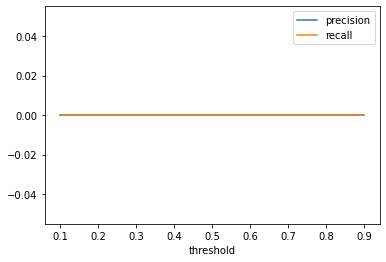

In [ ]:
# create the plot
pandas_df.plot.line(x='threshold', y=['precision','recall'])

# display the plot
plt.show()

#### We can see that for the positive class the prediction is very poor at varying thresholds too. 
#### We can say that Logistic Regression is not able to predict the positive class of this dataset

#### Updated model, if any
Repeat the steps 

#### Let us try setting a low threshold to verify how recall improves

In [ ]:
# create the logistic model, configure it and call fit it to the data. 
lr2 = LogisticRegression(featuresCol='features', labelCol='is_purchased')
lr2.setThreshold(0.1)
# Fitting the model on transformed df
model2 = lr2.fit(df_log_train)

In [ ]:
# use the model to predict the class labels of test data. 
model2_result = model2.evaluate(df_log_test)

In [ ]:
model2_result.recallByLabel

[0.9999993792841035, 0.0]

In [ ]:
model2_result.precisionByLabel

[0.975952337450925, 0.0]

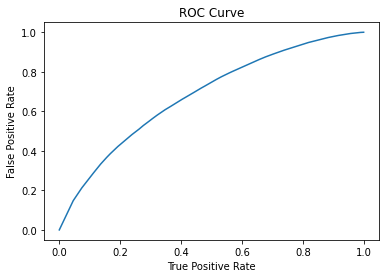

TestSet areaUnderROC: 0.6817025749252578


In [ ]:
# Checking ROC curve
lr_mode2_sum = model2.summary
lr2_roc = lr_mode2_sum.roc.toPandas()
plt.plot(lr2_roc['FPR'],lr2_roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('TestSet areaUnderROC: ' + str(lr_mode2_sum.areaUnderROC))

#### We can see that even after reducing the threshold there is no improvement in the metrics